La presentación es clara y cumple con el contenido esperado para el hito 2. 
Se replantea el objetivo del estudio y se aplican algunas recomendaciones del hito 1. 

Se describe un plan de trabajo que consiste en dos experimentos sin embargo la metodología no se plantea de forma apropiada (en las recomendaciones desarrollo este punto). Por otro lado, el procedimiento propuesto para responder la pregunta 1 no es correcto. Recordar que el uso de clustering les permitirá encontrar grupos que se dan naturalmente en un conjunto de datos, por lo que en la mayoría de los casos no es útil para encontrar relaciones con atributos específicos o variables objetivos. En este caso si usan las variables que tienen que ver con la difusión de un tweet encontrarán grupos que se distinguen entre si respecto a su difusión, pero es muy poco probable que esos grupos naturales estén además correlacionados con la magnitud. Incluso, suponiendo que de todas formas eso es lo que quieren verificar, no sería correcto incluir el parámetro de magnitud en el dataset para generar los clusters, porque eso sesgará esa "relación" que ustedes están intentando encontrar. 

## Recomendaciones: 
**Mejorar el planteamiento de la metodología**, recuerden que la metodología es como una receta paso a paso que busca seguir el método científico, que pueder servir para que alguien replique el experimento. La metodología de cada experimento debería incluir: pregunta que busca responder, método que se utilizará (clasificación, clustering, regresión, reglas de asociación) y por qué, algoritmos que se compararán y por qué, atributos que se considerarán y por qué, tratamiento adicional que será necesario para algoritmos específicos (ej. si será necesario usar PCA, balancear clases, discretizar o normalizar una variable, etc), cómo se dividirá el dataset entre datos de entrenamiento y testing en el caso de clasificación (%, crossvalidation) y por qué, cómo se definirán los hiperparámetros de cada algoritmo utilizado (n de vecinos en KNN, profundidad del árbol de decisión), cómo se evaluará el resultado y las métricas que se utilizarán. 
**Corregir experimento 1**. Esto podría requerir modificar la pregunta, ya que un tweet por si solo no les dirá mucho respecto a la magnitud de un evento. Por lo que les propongo reformular la pregunta para enfocarla netamente en la exploración de los tweets, es decir, una pregunta orientada a encontrar otros grupos (distintas a la clasificación del dataset) que se den naturalmente en los tweets que se generan en eventos de crisis, donde tendrían la a **grupación realizada en base a qué tan viral fue el tweet**, pero podrían darse otras agrupaciones si incluyen otras categorías que logren extraer de los datos o del del procesamiento del texto, como: **largo del tweet, si tiene o no foto, si menciona ciertas palabras clave que consideren relevantes, etc**.

### Pre procesamiento

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import regex as re


import os
def get_hashtags_text(x):
    if pd.notna(x) and 'hashtags' in x and x['hashtags']:
        hashtags = x['hashtags']
        hashtags_text = [ht['text'] for ht in hashtags]
        return hashtags_text
    else:
        return None

def get_urls(x):
    if pd.notna(x) and 'urls' in x and x['urls']:
        return True
    return False


def get_user_location(x):
    if pd.notna(x) and 'location' in x:
        return x['location']
    else:
        return None


def load_json(file_path):
    df_new = pd.DataFrame()

    try:
        # Leer el archivo JSON línea por línea y cargar los datos en una lista
        datos_json = []
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                data = json.loads(line)
                if 'retweeted_status' in data and data['retweeted_status'] != None:
                    data = data['retweeted_status']
                datos_json.append(data)

        df = pd.DataFrame(datos_json)

        df_new['id'] = df['id']
        df_new['lang'] = df['lang']
        df_new['text'] = df['text']
        df_new['favorite_count'] = df['favorite_count']
        df_new['retweet_count'] = df['retweet_count']
        df_new['possibly_sensitive'] = df['possibly_sensitive']
        df_new['created_at'] = df['created_at']
        df_new['is_quote_status'] = df['is_quote_status']
        df_new['entities_hashtags_text'] = df['entities'].apply(get_hashtags_text)
        df_new['entities_urls'] = df['entities'].apply(get_urls)
        df_new['user_location'] = df['user'].apply(get_user_location)
        
        # Asignar 0 a las columnas 'reply_count' y 'quote_count' si no existen
        df_new['reply_count'] = df.get('reply_count', 0)
        df_new['quote_count'] = df.get('quote_count', 0)

        # Verificar si hay al menos una imagen en el JSON
        has_image = []
        for i in range(len(df)):
            try:
                extended_entities = df['extended_entities'][i]
                if 'media' in extended_entities and len(extended_entities['media']) > 0:
                    has_image.append(True)
                else:
                    has_image.append(False)
            except (KeyError, TypeError):
                has_image.append(False)

        df_new['has_image'] = has_image

    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_new


def load_jsons_from_folder(folder_path):
    df_all = pd.DataFrame()

    try:
        # Obtener la lista de archivos en la carpeta
        json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

        for file_name in json_files:
            file_path = os.path.join(folder_path, file_name)
            df = load_json(file_path)

            # Extraer el nombre del archivo sin "_final_data.json"
            json_name = file_name.replace('_final_data.json', '')

            # Agregar columna con el nombre del JSON
            df['json_name'] = json_name

            # Concatenar el DataFrame al DataFrame total
            df_all = pd.concat([df_all, df], ignore_index=True)

    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_all

def read_tsv_folder(folder_path):
    df_combined = pd.DataFrame()  # DataFrame combinado para almacenar los datos de todos los archivos TSV

    # Obtener la lista de archivos en la carpeta
    file_list = os.listdir(folder_path)

    # Leer cada archivo TSV y combinar los datos en el DataFrame combinado
    for file_name in file_list:
        if file_name.endswith(".tsv"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, sep="\t")
            df_combined = pd.concat([df_combined, df], ignore_index=True)

    return df_combined


df_json = load_jsons_from_folder("RDATA/CrisisMMD_v2.0/json")
df_tsv = read_tsv_folder("RDATA/CrisisMMD_v2.0/annotations")


df = pd.merge(df_json, df_tsv[['tweet_id', 'text_info', 'text_info_conf', 'text_human', 'text_human_conf']],
                    left_on='id', right_on='tweet_id', how='left')
df.drop('tweet_id',axis=1,inplace=True)
df_con_nan = df.copy()
df =  df[df['text_human'].notna()]

import pandas as pd
from datetime import datetime as dt
df_con_nan["fecha"] = pd.to_datetime(df_con_nan['created_at'], format='%a %b %d %H:%M:%S %z %Y')
df["fecha"] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')
#print(a[1000]<a[1])

#df_con_nan
#print(mdates.DateFormatter(df_con_nan['created_at']))
df_con_nan = df_con_nan[df_con_nan['fecha'] >= '2017']


import pytz
from datetime import datetime

def foo(d):
    fecha = d
    fecha_objeto = datetime.strptime(fecha, "%b %d, %Y")
    fecha_transformada = fecha_objeto.strftime("%Y-%m-%d")
    return fecha_transformada

def convertir_fecha(fecha):
    fecha_dt = datetime.strptime(fecha, "%a %b %d %H:%M:%S %z %Y")
    fecha_formato = fecha_dt.strftime("%Y-%m-%d %H:%M:%S")
    return fecha_formato

#print(foo("Oct 10, 2017"))
l = ["Oct 10, 2017", "Aug 26, 2017", "Sep 6, 2017", "Sep 20, 2017", "Nov 13, 2017", "Sep 20, 2017"]
l1 = ["10-10-2017", "26-08-2017", "06-09-2017", "20-09-2017", "13-11-2017", "20-09-2017", "20-05-2017"]

fechas = list(map(foo, l))
#print(fechas)

df_con_nan["tdd_temp"] = 0  # Crear una nueva columna temporal

i = 0
for desastre in df_con_nan['json_name'].unique():
    d = df_con_nan[df_con_nan['json_name'] == desastre]

    AA = d["created_at"]
    BB = pd.to_datetime(l1[i], dayfirst=True, format="%d-%m-%Y").tz_localize(pytz.UTC)
    df_con_nan.loc[df_con_nan['json_name'] == desastre, "tdd_temp"] = (pd.to_datetime(AA, format="%a %b %d %H:%M:%S %z %Y") - BB).dt.days
    #print()
    #print(df_con_nan[df_con_nan["json_name"] == desastre][["tdd_temp", "created_at"]])

    i += 1

df_con_nan["tdd"] = df_con_nan["tdd_temp"]  # Asignar la columna temporal a la columna "tdd"
df_con_nan.drop("tdd_temp", axis=1, inplace=True)  # Eliminar la columna temporal
df_con_nan = df_con_nan[df_con_nan["tdd"] > -5]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Funcion en pandas que genera un archivo csv con los datos de un dataframe
def generar_csv(df, nombre_archivo):
    df.to_csv(nombre_archivo, index=False)

generar_csv(df_con_nan,"datos.csv")

### Lematizacion

In [5]:

from spacy.lang.en.stop_words import STOP_WORDS
import re
import string
from nltk.corpus import stopwords

# function that remove stopwords in english from de dataframe column "text" and remove caps ,empty spaces and symbols
# also separate the words with '#' , '@' '’' and "'" or any symbols from the text
def remove_stopwords(df, additional_stopwords=[]):
    # remove stopwords
    df['text_clean'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))
    # remove caps
    df['text_clean'] = df['text_clean'].apply(lambda x: x.lower())
    # remove empty spaces
    df['text_clean'] = df['text_clean'].apply(lambda x: x.strip())
    # remove simbols
    df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    # remove numbers
    df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'[0-9]', '', x))
    # remove additional stopwords
    df['text_clean'] = df['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (additional_stopwords)]))
    # remove single letters
    df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'\b\w{1}\b', '', x))
    # remove words that starts with http
    df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'http\S+', '', x))
    # remove empty spaces , only having single space betwween words
    df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'\s+', ' ', x))

remove_stopwords(df_con_nan, ['california','californias', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st',"mora",'californiawildfires' ])

df_con_nan

,id,lang,text,favorite_count,retweet_count,possibly_sensitive,created_at,is_quote_status,entities_hashtags_text,entities_urls,...,quote_count,has_image,json_name,text_info,text_info_conf,text_human,text_human_conf,fecha,tdd,text_clean
0,917791130590183424,en,PHOTOS: Deadly wildfires rage in California ht...,0,0,False,Tue Oct 10 16:37:11 +0000 2017,False,None,True,...,0.0,True,california_wildfires,informative,1.0000,infrastructure_and_utility_damage,1.0000,2017-10-10 16:37:11+00:00,0,photos deadly rage
1,917787635946524674,en,Wildfires raging through Northern California a...,7,5,False,Tue Oct 10 16:23:18 +0000 2017,False,None,True,...,4.0,True,california_wildfires,NaN,NaN,NaN,NaN,2017-10-10 16:23:18+00:00,0,raging northern terrifying
2,917500054742605829,en,"PLS SHARE: We’re capturing wildfire response, ...",289,479,False,Mon Oct 09 21:20:34 +0000 2017,False,None,True,...,25.0,True,california_wildfires,NaN,NaN,NaN,NaN,2017-10-09 21:20:34+00:00,-1,pls share were capturing response recovery inf...
3,917623252264062976,en,California's raging wildfires as you've never ...,228,216,False,Tue Oct 10 05:30:06 +0000 2017,False,None,True,...,18.0,True,california_wildfires,NaN,NaN,NaN,NaN,2017-10-10 05:30:06+00:00,0,raging youve seen
4,917792930315821057,en,Mass Evacuations in California as Wildfires Ki...,0,0,False,Tue Oct 10 16:44:21 +0000 2017,False,[CaliforniaWildfires],True,...,0.0,True,california_wildfires,informative,1.0000,injured_or_dead_people,1.0000,2017-10-10 16:44:21+00:00,0,mass evacuations kill least
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17627,881714673157980160,en,Get to mora and try the whole menu https://t.c...,0,0,False,Mon Jul 03 03:22:14 +0000 2017,False,None,False,...,0.0,True,srilanka_floods,not_informative,1.0000,not_humanitarian,1.0000,2017-07-03 03:22:14+00:00,44,get try menu
17628,881749861871362049,en,"Mirka Mora (b.1928), noted French-born Austral...",0,0,False,Mon Jul 03 05:42:03 +0000 2017,False,[womensart],False,...,0.0,True,srilanka_floods,not_informative,1.0000,not_humanitarian,1.0000,2017-07-03 05:42:03+00:00,44,mirka noted frenchborn australian colourist sy...
17629,881770990556131328,en,"@PaulMalignaggi Lol What u on about, Sergio Mo...",0,0,False,Mon Jul 03 07:06:01 +0000 2017,False,None,False,...,0.0,True,srilanka_floods,not_informative,1.0000,not_humanitarian,1.0000,2017-07-03 07:06:01+00:00,44,paulmalignaggi lol what about sergio didnt hor...
17630,881807298930368513,en,#Cameroon : 4 #female suicide #Bombers kill 1 ...,0,0,False,Mon Jul 03 09:30:17 +0000 2017,False,"[Cameroon, female, Bombers]",True,...,0.0,True,srilanka_floods,not_informative,0.5056,not_humanitarian,0.5056,2017-07-03 09:30:17+00:00,44,cameroon female suicide bombers kill


In [6]:
import spacy
#python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")


def get_lemma(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

df_con_nan["lemma"] = df_con_nan["text_clean"].apply(get_lemma)
df_con_nan["lemma"]

0                                    [photo, deadly, rage]
1                             [rage, northern, terrifying]
2        [pls, share, be, capture, response, recovery, ...
3                                     [rage, you, ve, see]
4                          [mass, evacuation, kill, least]
                               ...                        
17627                                     [get, try, menu]
17628    [mirka, note, frenchborn, australian, colouris...
17629    [paulmalignaggi, lol, what, about, sergio, do,...
17630            [cameroon, female, suicide, bomber, kill]
17631             [happen, visit, cyclonemora, bangladesh]
Name: lemma, Length: 17544, dtype: object

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=1000)




# Entrena el modelo con los textos lematizados
def entrenar_modelo(df):
    textos = df["lemma"].tolist()
    textos = [" ".join(lista) for lista in textos] # Esta es la línea que debes añadir
    X = tfidf.fit_transform(textos)
    return X

X = entrenar_modelo(df_con_nan)
print(X.shape)

X

(17544, 1000)


<17544x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 63640 stored elements in Compressed Sparse Row format>

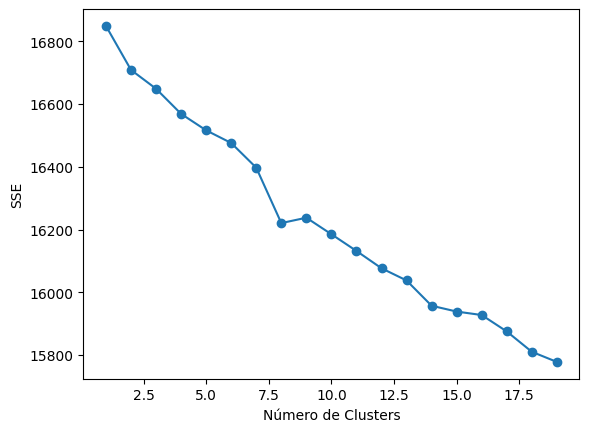

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
SSE = []
numClusters = list(range(1, 20))
for k in numClusters:
    k_means = KMeans(n_clusters=k, n_init=10, random_state=1)
    k_means.fit(X)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE, marker="o")
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


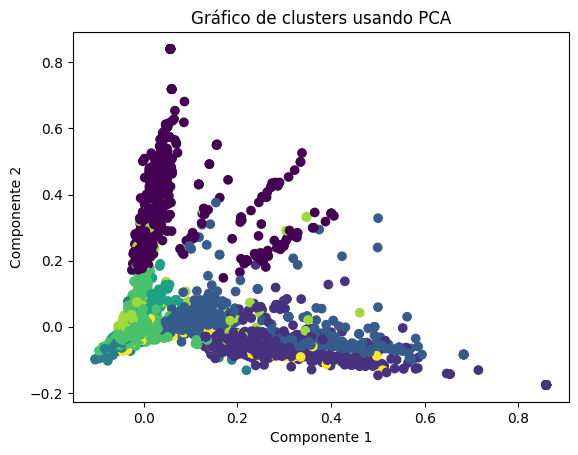

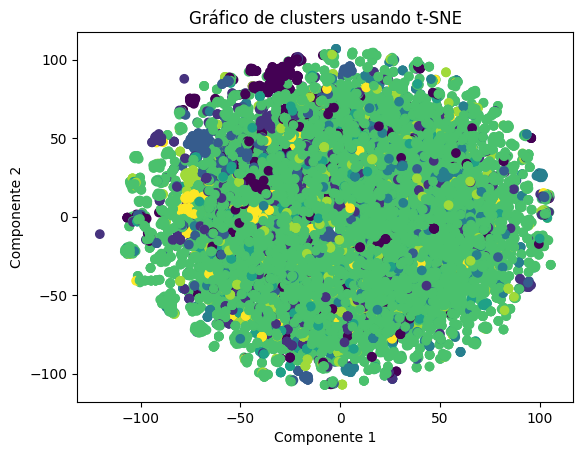

In [12]:


kmeans = KMeans(n_clusters=8, random_state=0)
y = kmeans.fit_predict(X)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Usando PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.title("Gráfico de clusters usando PCA")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

# Usando t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X.toarray())
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
plt.title("Gráfico de clusters usando t-SNE")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()




In [15]:
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000617,0.001612,0.000461,0.000885,0.000000,0.000000,0.000604,0.003253,0.000000,0.003128,...,0.000000,0.000000,0.000000,0.000000,0.000608,0.000857,0.000828,0.000982,0.001813,0.001315
1,0.000000,0.001489,0.003777,0.000825,0.000000,0.000000,0.000561,0.019606,0.001372,0.003741,...,0.000000,0.000553,0.000000,0.000000,0.001215,0.000000,0.000616,0.001678,0.000000,0.001629
2,0.001689,0.000000,0.003799,0.000000,0.000739,0.000000,0.000000,0.001625,0.000000,0.000657,...,0.000000,0.000000,0.001496,0.000000,0.000612,0.000000,0.002270,0.001073,0.000819,0.000557
3,0.000861,0.000000,0.000535,0.000000,0.000725,0.000000,0.001625,0.003543,0.000000,0.003493,...,0.000000,0.000000,0.000000,0.000000,0.000680,0.000000,0.000000,0.000000,0.000586,0.000000
4,0.000894,0.000800,0.000000,0.000000,0.001264,0.000748,0.000000,0.007542,0.002495,0.000640,...,0.000000,0.000000,0.000000,0.005102,0.001078,0.000000,0.002044,0.000000,0.001209,0.000000
5,0.000716,0.001087,0.001867,0.000846,0.000767,0.000954,0.000626,0.006372,0.000537,0.005732,...,0.001180,0.000917,0.000746,0.000872,0.003752,0.000917,0.001487,0.001476,0.000873,0.000773
6,0.000827,0.000639,0.000000,0.000000,0.001613,0.002359,0.000000,0.007539,0.004088,0.001846,...,0.000617,0.000000,0.003454,0.001226,0.002911,0.000000,0.002801,0.000519,0.000000,0.002444
7,0.000000,0.000000,0.000000,0.000000,0.004542,0.000000,0.001391,0.035660,0.000000,0.005778,...,0.000000,0.003908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003109,0.001669


In [53]:
from sklearn.decomposition import SparsePCA
spca = SparsePCA(n_components=5)
X_spca = spca.fit_transform(X.toarray())

plt.scatter(X_spca[:, 0], X_spca[:, 1], c=kmeans.labels_)
plt.title("Gráfico de clusters usando t-SNE")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()



### Embeddings

In [2]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopword_tokens
import numpy as np


# Supongamos que tienes una lista de oraciones en la columna de texto
sentences = df["text"].tolist()

stop_words = set(stopwords.words('english'))
additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st']
stop_words.update(additional_stop_words)

# Tokeniza las oraciones y crea una lista de listas de palabras
#tokenized_sentences = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in sentences]


# Definir los parámetros del modelo Word2Vec
vector_size = 100  # Dimensión del espacio vectorial
window_size = 5  # Tamaño de la ventana de contexto
min_count = 1  # Frecuencia mínima de las palabras para ser consideradas

def cargar_embeddings_glove(ruta_archivo):
    embeddings_index = {}
    with open(ruta_archivo, encoding='utf-8') as archivo:
        for linea in archivo:
            valores = linea.split()
            palabra = valores[0]
            vector = np.asarray(valores[1:], dtype='float32')
            embeddings_index[palabra] = vector
    return embeddings_index

ruta_archivo_glove = "glove/glove.6B.200d.txt"  # Reemplaza con la ruta real de tu archivo GloVe
embeddings_glove = cargar_embeddings_glove(ruta_archivo_glove)

In [3]:
from sklearn.model_selection import train_test_split

# Carga el dataset en un DataFrame de pandas

# Divide los datos en características (X) y etiquetas (y)
X = df['text'].values  # Reemplaza 'columna_de_texto' con el nombre real de tu columna
y = df['text_human'].values  # Reemplaza 'columna_etiquetas' con el nombre real de tu columna de etiquetas

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from gensim.utils import simple_preprocess
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np

stop_words = STOP_WORDS
additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st',"mora"]
stop_words.update(additional_stop_words)

tokenized_sentences_train = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_train]
tokenized_sentences_test = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_test]

# vectors_train = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_train]
# vectors_test = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_test]

vectors_train = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_train]
vectors_test = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_test]


def average_vectors(vectors):
    averaged_vectors = []
    for sentence_vectors in vectors:
        if len(sentence_vectors) > 0:
            averaged_vectors.append(np.mean(sentence_vectors, axis=0))
        else:
            averaged_vectors.append(np.zeros(200))
    return averaged_vectors

X_train_embeddings = average_vectors(vectors_train)
X_test_embeddings = average_vectors(vectors_test)

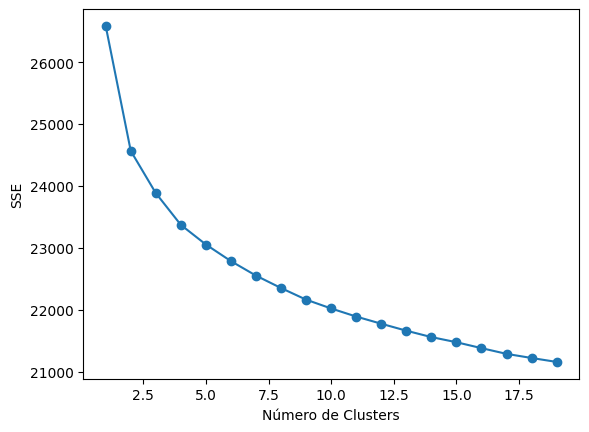

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

SSE = []
numClusters = list(range(1, 20))
for k in numClusters:
    k_means = KMeans(n_clusters=k, n_init=10, random_state=1)
    k_means.fit(X_train_embeddings)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE, marker="o")
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

In [21]:


# 1. Selección del algoritmo de clustering
n_clusters = 4  # Número de clusters deseado

# 2. Entrenamiento del modelo de clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train_embeddings)

# 3. Predicción de clusters
train_clusters = kmeans.predict(X_train_embeddings)
test_clusters = kmeans.predict(X_test_embeddings)

# 4. Evaluación del clustering
train_silhouette_score = silhouette_score(X_train_embeddings, train_clusters)
test_silhouette_score = silhouette_score(X_test_embeddings, test_clusters)

print("Silhouette Score (train):", train_silhouette_score)
print("Silhouette Score (test):", test_silhouette_score)

# 5. Interpretación de los clusters
cluster_labels = kmeans.labels_
df_clusters = pd.DataFrame({'text': X_train, 'cluster_label': cluster_labels})
for cluster_label in range(n_clusters):
    cluster_samples = df_clusters[df_clusters['cluster_label'] == cluster_label]['text']
    print("Cluster", cluster_label)
    print(cluster_samples)
    print()


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score (train): 0.03347529043974475
Silhouette Score (test): 0.0312814361742332
Cluster 0
11       CHP Keeps Hospital Running During Hurricane Ha...
17       Mora Meza: Review — Lady Wimbledon https://t.c...
20       Skeptics, PJ Harvey and Skeptics from Ali ☺️ h...
28       IRMA !! Dramatic Hurricane IRMA FOOTAGE [TERRI...
29       Lago Luchetti Lago Luchetti is located in Yauc...
                               ...                        
12355    Oh the places you will go... #jnj @donateaphot...
12357    Candles and Soaps for sale to help Harvey vict...
12372    @jstar79 @atxwxgirl @lastcrazyhorn @tlm101 shi...
12374    MN man searches for family in Puerto Rico http...
12375    Wheel Wednesday all the way from Puerto Rico ἟...
Name: text, Length: 3077, dtype: object

Cluster 1
0        Wow, never seen so many birds on the lawn, as ...
3        Please RT #weddings #brides Low-Key Glam Desti...
6        Just relaxing ὠC &amp; thinking ὊDᾑ4 about my ...
8        Shop our #hope

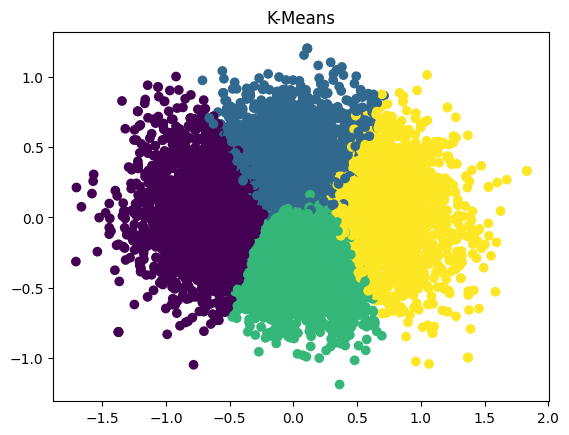

In [35]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_train_embeddings)
df_pca = pca.transform(X_train_embeddings) 

#scatter para cada caso


plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_)
plt.title("K-Means")
plt.show()

Cluster 0
Keywords: ['Hurricane', 'in', 'to', 'the', 'of', 'Harvey', 'Irma', 'Puerto', 'for', 'and']

Cluster 1
Keywords: ['to', 'in', 'the', 'of', 'Hurricane', 'and', 'for', 'a', 'Puerto', 'Irma']

Cluster 2
Keywords: ['to', 'in', 'Hurricane', 'of', 'Puerto', 'Harvey', 'for', 'the', 'Rico', 'Irma']

Cluster 3
Keywords: ['to', 'the', 'in', 'of', 'for', 'a', 'and', 'Hurricane', 'is', 'Puerto']



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...


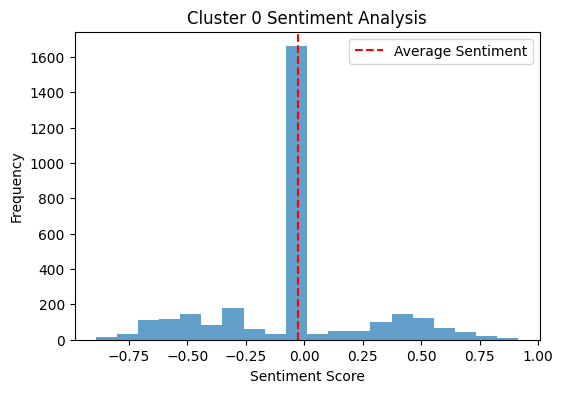

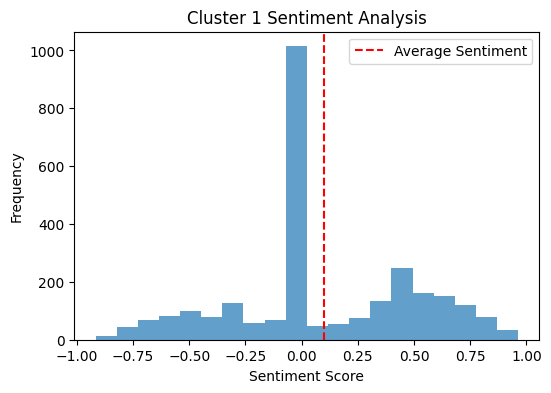

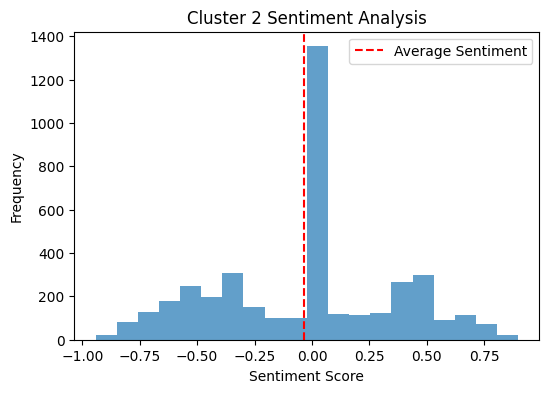

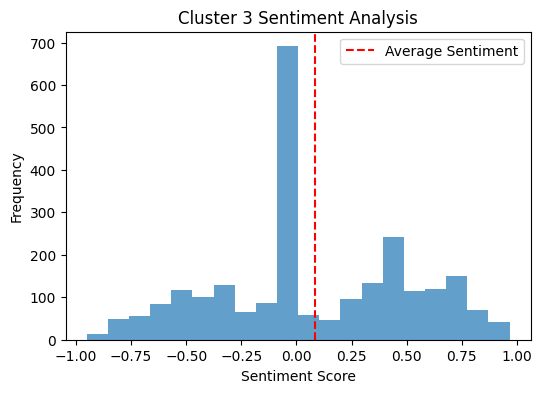

In [39]:
from collections import Counter

def get_cluster_keywords(cluster_label, cluster_samples, num_keywords=10):
    cluster_text = ' '.join(cluster_samples)
    tokenized_text = cluster_text.split()
    word_counts = Counter(tokenized_text)
    most_common_keywords = word_counts.most_common(num_keywords)
    return [keyword for keyword, count in most_common_keywords]

for cluster_label in range(n_clusters):
    cluster_samples = df_clusters[df_clusters['cluster_label'] == cluster_label]['text']
    cluster_keywords = get_cluster_keywords(cluster_label, cluster_samples)
    print("Cluster", cluster_label)
    print("Keywords:", cluster_keywords)
    print()

import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
# Punto 4: Análisis de sentimiento por cluster
def analyze_cluster_sentiment(cluster_label, cluster_samples):
    sid = SentimentIntensityAnalyzer()
    sentiments = [sid.polarity_scores(sample)['compound'] for sample in cluster_samples]
    average_sentiment = sum(sentiments) / len(sentiments)
    
    plt.figure(figsize=(6, 4))
    plt.hist(sentiments, bins=20, alpha=0.7)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.title(f'Cluster {cluster_label} Sentiment Analysis')
    plt.axvline(x=average_sentiment, color='red', linestyle='--', label='Average Sentiment')
    plt.legend()
    plt.show()

for cluster_label in range(n_clusters):
    cluster_samples = df_clusters[df_clusters['cluster_label'] == cluster_label]['text']
    analyze_cluster_sentiment(cluster_label, cluster_samples)


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Crear el objeto TfidfVectorizer
vectorizer = TfidfVectorizer()

# Obtener las representaciones TF-IDF de los textos de los clusters
cluster_tfidf_vectors = []
for cluster_label in range(n_clusters):
    cluster_samples = df_clusters[df_clusters['cluster_label'] == cluster_label]['text']
    cluster_tfidf = vectorizer.fit_transform(cluster_samples)
    cluster_tfidf_vectors.append(cluster_tfidf)

# Calcular la matriz de similitud de coseno para cada par de clusters
similarity_matrix = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        similarity = cosine_similarity(cluster_tfidf_vectors[i], cluster_tfidf_vectors[j])
        similarity_matrix[i, j] = similarity

# Imprimir la matriz de similitud
print(similarity_matrix)




ValueError: setting an array element with a sequence.

In [22]:
cluster0 = df_clusters[df_clusters["cluster_label"]==0].copy()
cluster0[cluster0["text"].str.contains("mora",regex=False)]

,text,cluster_label
254,#SDCC2017 Exclusive: @boomstudios – SABAN'S GO...,0
1624,what could i say mora than I ADORE JUNHOE\nDEE...,0
2618,After cyclone #mora #RCY Rangamati is in actio...,0
3668,Pay con mora :3 https://t.co/mconP4fhwp,0
4176,Mora mora beach #sanfoca #gigiesara #1anno #an...,0
4833,After cyclone #mora #RCY Rangamati is in actio...,0
5061,mora in a nutshell https://t.co/IQFWKiTOxJ,0
5186,My mora mora ὠDὠDὠDὠD https://t.co/dg4O1Q0mI0,0
5264,40 dana do mora and counting ἰAἰAἰAὁFὁFὁFὂ0ὂ0ὂ...,0
5502,Isso porque a dona do post n mora em svp TRIST...,0


In [30]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

text_data = df['text'].str.split().tolist()
all_words = [word.lower() for sublist in text_data for word in sublist]

def clean_and_tokenize2(text):
    # Eliminar caracteres especiales y hashtags pegados a palabras
    cleaned_text = re.sub(r"[^\w\s]|(#\w+)", "", text)

    # Tokenizar el texto
    tokens = word_tokenize(cleaned_text.lower())

    # Eliminar stopwords en inglés y palabras adicionales
    stop_words = set(stopwords.words('english'))
    additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st','amp',"mora"]
    stop_words.update(additional_stop_words)

    # Agregar números a la lista de stopwords
    stop_words.update(additional_stop_words)
    stop_words.update(set(token for token in tokens if token.isdigit()))

    # Filtrar las palabras
    filtered_tokens = [token for token in tokens if token not in stop_words]

    return filtered_tokens


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


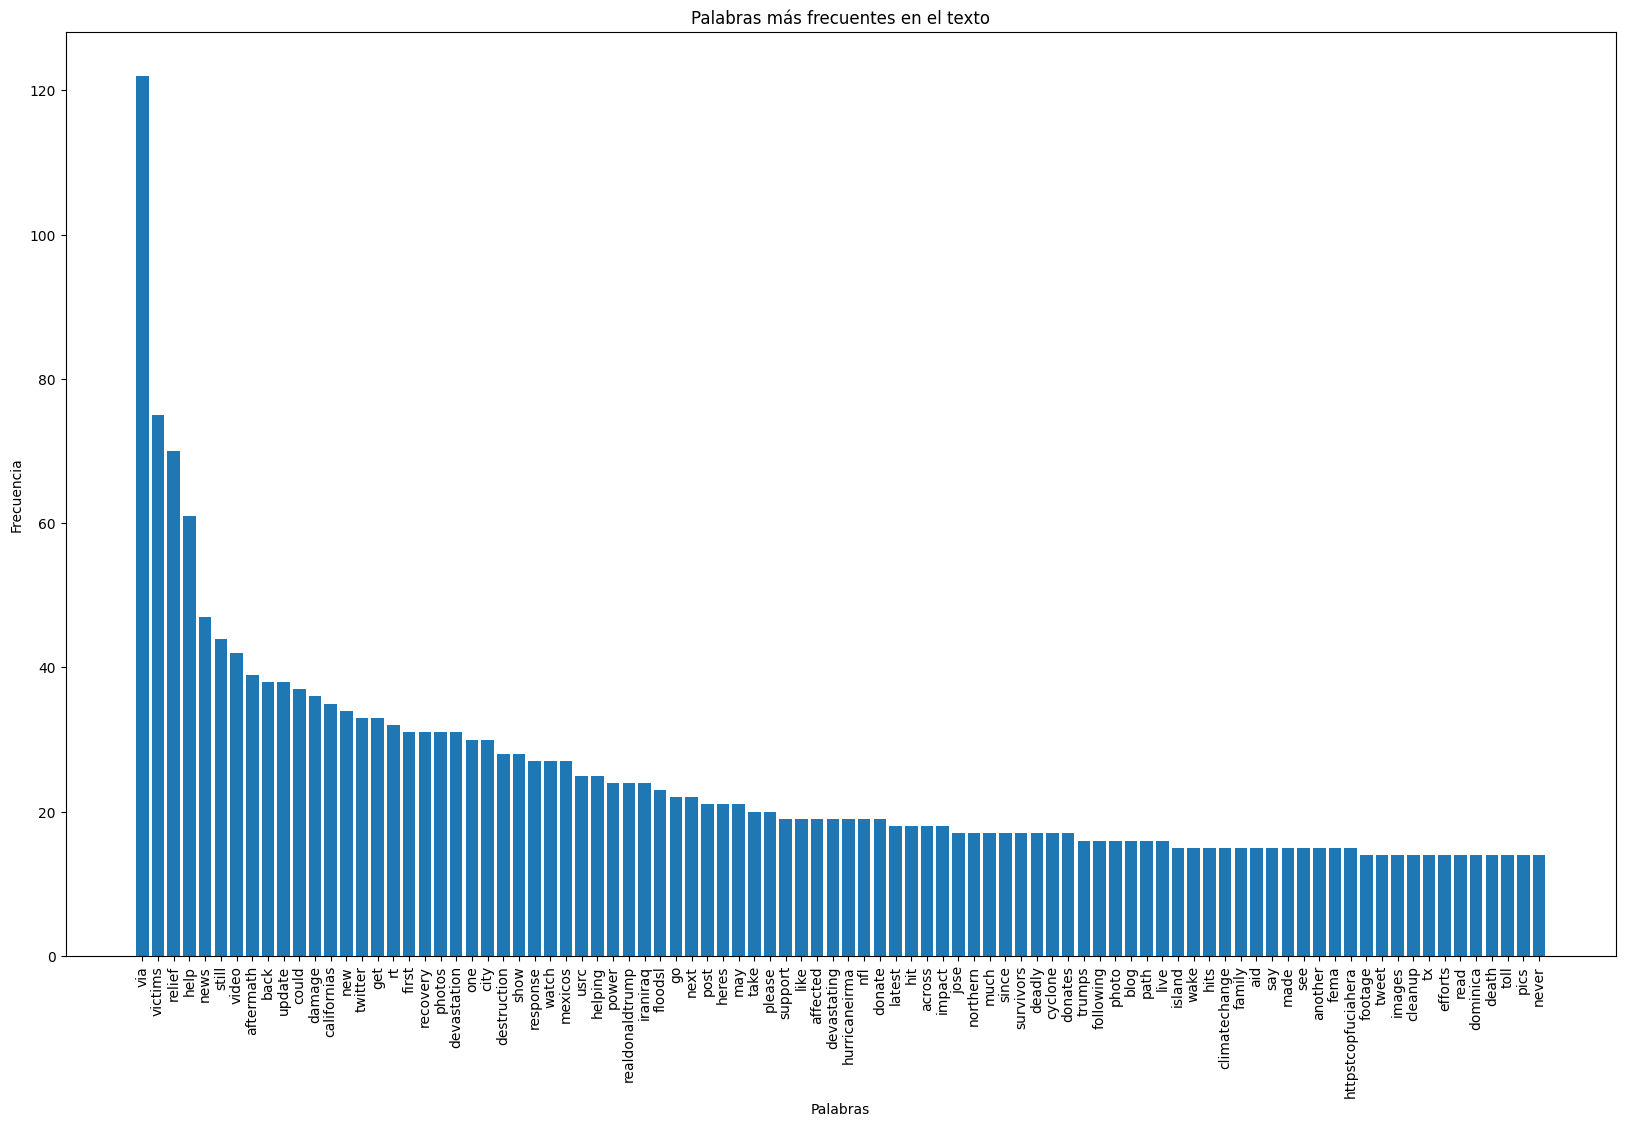

In [31]:
# Obtener las palabras y sus frecuencias en la columna "text"
words = df_clusters[df_clusters["cluster_label"]==0]["text"].apply(clean_and_tokenize2).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()

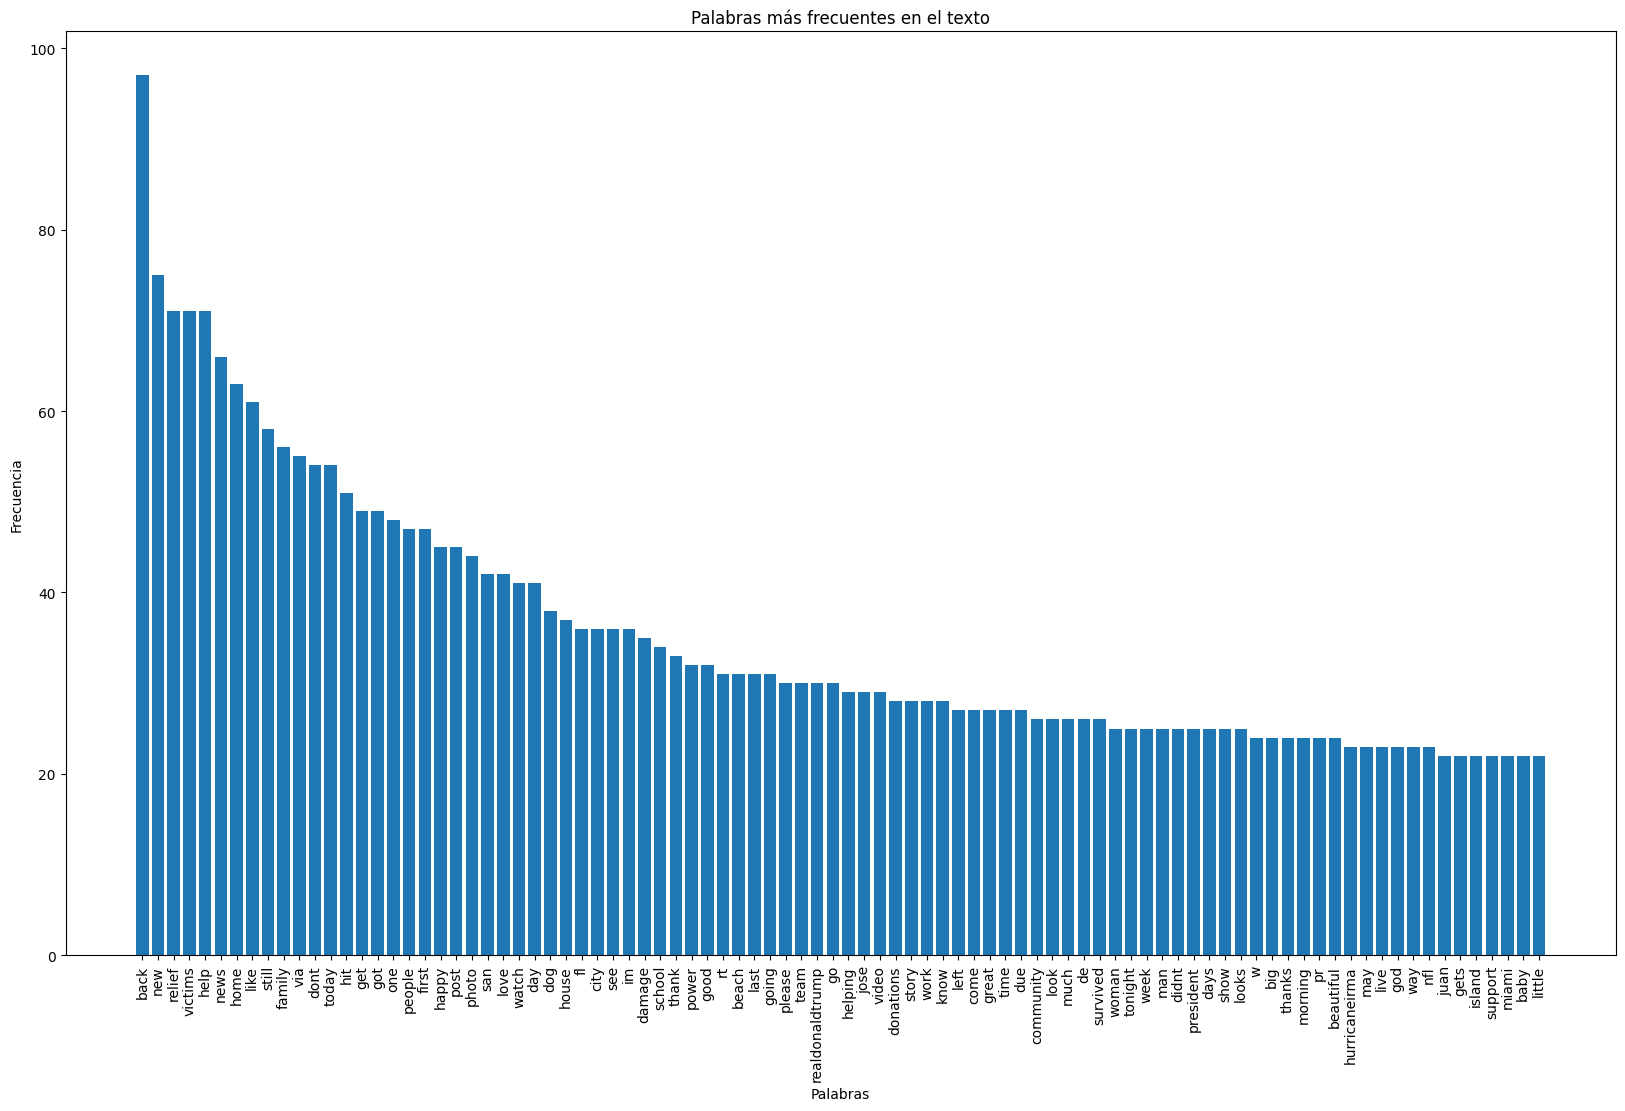

In [32]:
# Obtener las palabras y sus frecuencias en la columna "text"
words = df_clusters[df_clusters["cluster_label"]==1]["text"].apply(clean_and_tokenize2).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()

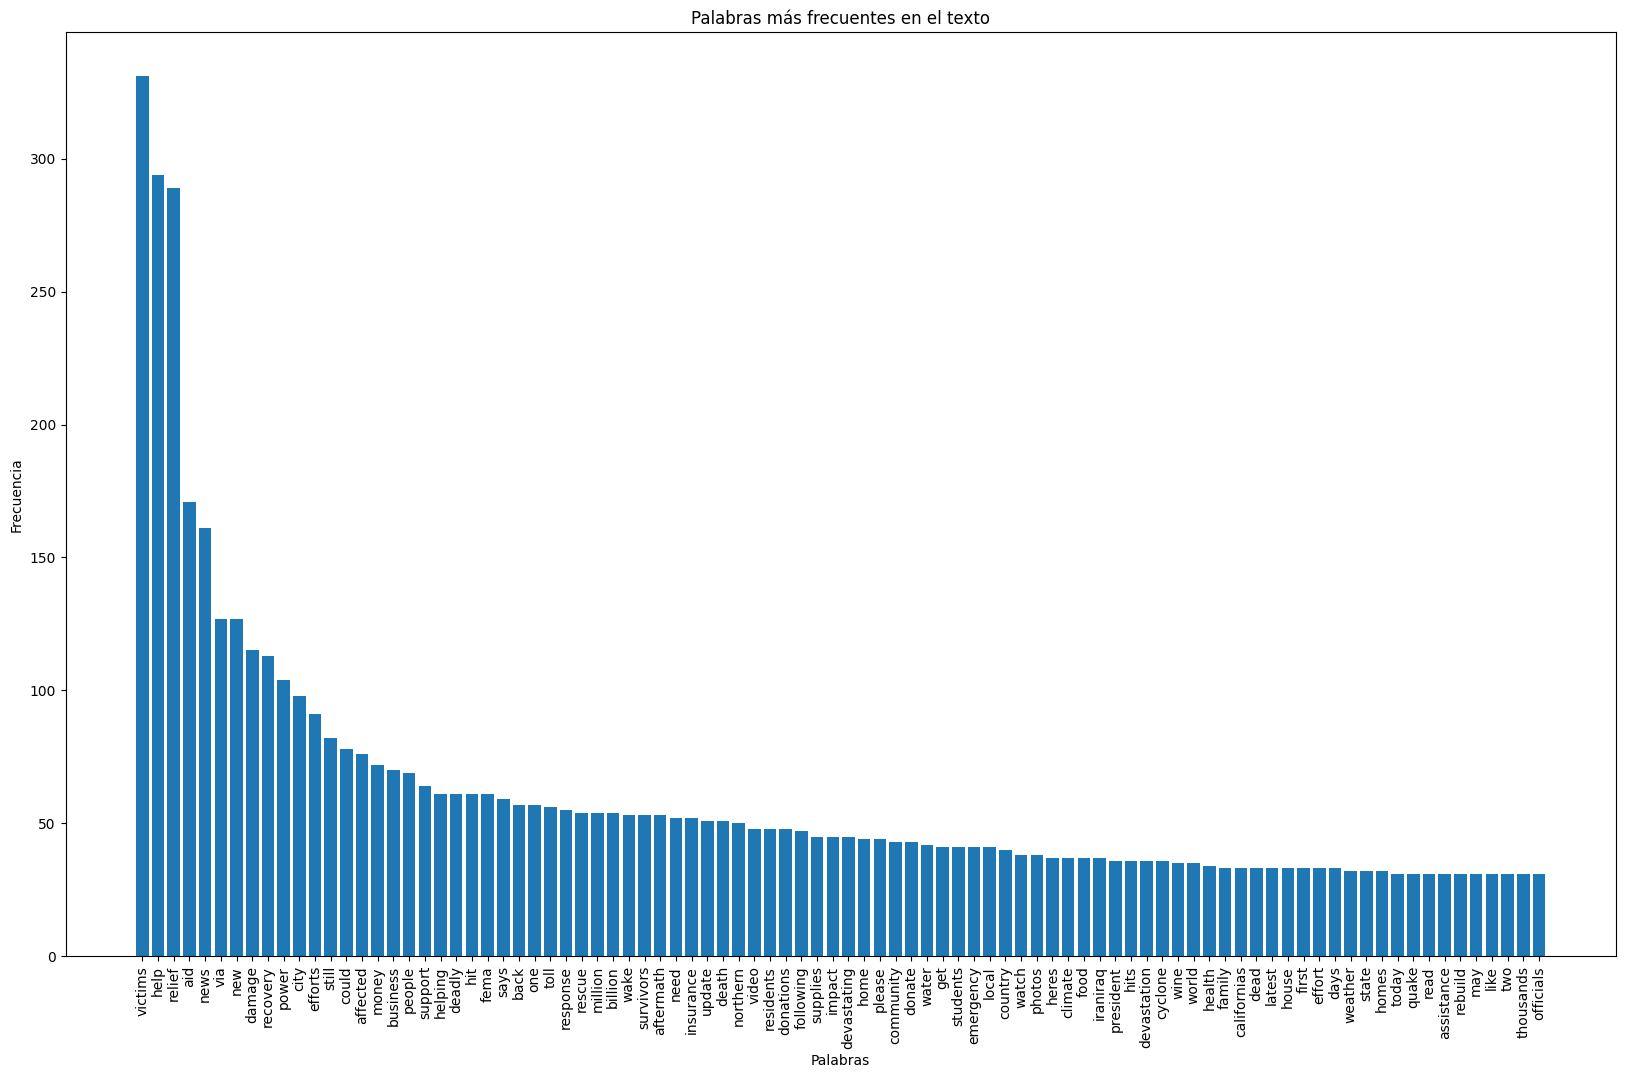

In [33]:
# Obtener las palabras y sus frecuencias en la columna "text"
words = df_clusters[df_clusters["cluster_label"]==2]["text"].apply(clean_and_tokenize2).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()

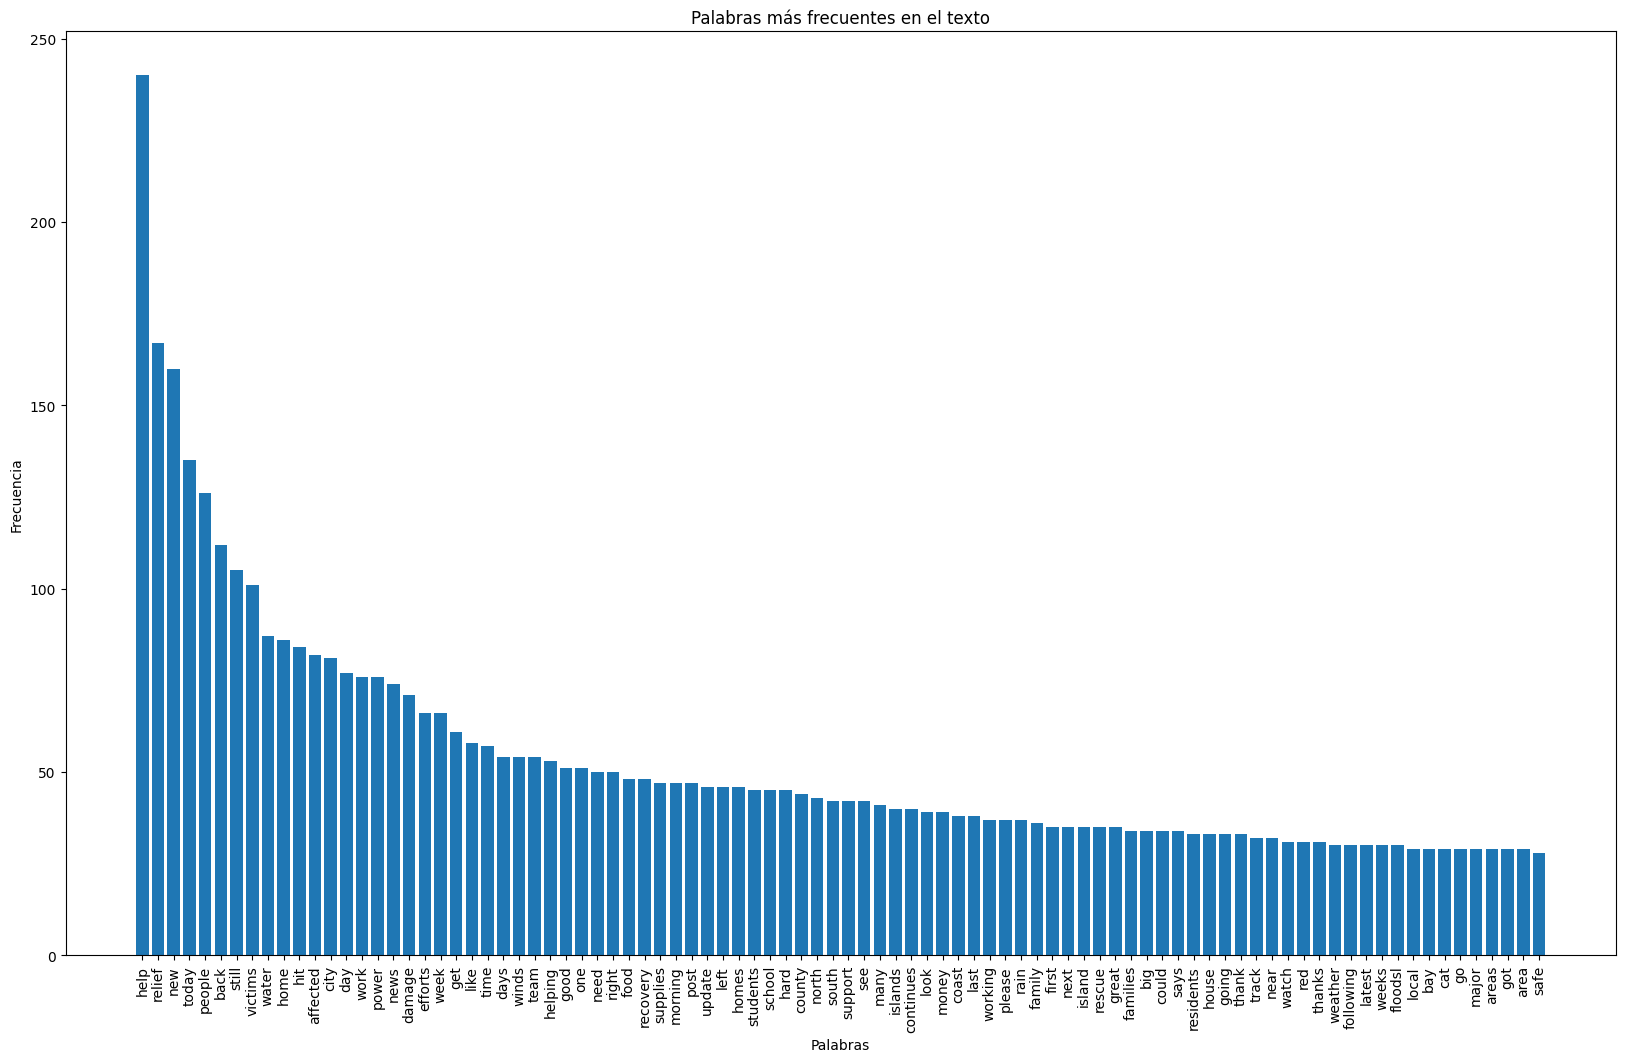

In [34]:
# Obtener las palabras y sus frecuencias en la columna "text"
words = df_clusters[df_clusters["cluster_label"]==3]["text"].apply(clean_and_tokenize2).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()

In [4]:
print(df_con_nan.shape)
print(df.shape)



muertes = {"mexico_earthquake":369,
       "hurricane_harvey":107,
       "hurricane_irma":134,
       "iraq_iran_earthquake":630,
       "hurricane_maria":3059,
       "srilanka_floods":203,
       "california_wildfires":46}
heridos = {}
viviendas ={}
perdida_economica = {}
magnitud = {}

(17544, 21)
(15477, 20)
